In [5]:
from math import sqrt

import torch
import matplotlib.pyplot as plt

from simple_truss import Truss

torch.set_default_dtype(torch.double)

# Sample truss

In [6]:
n1 = torch.linspace(0.0, 4.0, 5)
n2 = torch.linspace(0.0, 1.0, 2)
n1, n2 = torch.stack(torch.meshgrid(n1, n2, indexing="xy"))
nodes = torch.stack([n1.ravel(), n2.ravel()], dim=1)

elements = [
    [0, 1],
    [1, 2],
    [2, 3],
    [3, 4],
    [5, 6],
    [6, 7],
    [7, 8],
    [8, 9],
    [1, 5],
    [0, 6],
    [2, 6],
    [1, 7],
    [3, 7],
    [2, 8],
    [4, 8],
    [3, 9],
    [1, 6],
    [2, 7],
    [3, 8],
    [4, 9],
]

forces = torch.zeros_like(nodes)
forces[4, 1] = -0.1
constraints = torch.zeros_like(nodes, dtype=bool)
constraints[0, 0] = True
constraints[0, 1] = True
constraints[5, 0] = True
areas = 10 * torch.ones((len(elements)))

truss_sample = Truss(nodes, elements, forces, constraints, areas, E=1.0)

## The optimization

In [7]:
def newton(grad, mu_init, max_iter=10, tol=0.0001):
    # Newton's method to find root of grad (few iterations, if succesfull)
    mu = torch.tensor([mu_init], requires_grad=True)
    i = 0
    while torch.abs(grad(mu)) > tol:
        if i > max_iter:
            raise Exception(f"Newton solver did not converge in {max_iter} iterations.")
        gradgrad = torch.autograd.grad(grad(mu).sum(), mu)[0]
        mu.data -= grad(mu) / gradgrad
        mu.data = torch.maximum(mu.data, torch.tensor([0.0]))
        i += 1
    return mu.data


def bisection(grad, a, b, max_iter=50, tol=1e-10):
    # Bisection method always finds a root, even with highly non-linear grad
    i = 0
    while (b - a) > tol:
        c = (a + b) / 2.0
        if i > max_iter:
            raise Exception(f"Bisection did not converge in {max_iter} iterations.")
        if grad(a) * grad(c) > 0:
            a = c
        else:
            b = c
        i += 1
    return c


def optimize(truss, a_0, a_min, a_max, V_0, iter=10, s=0.7,p=1.0):
    a = [a_0]
    L = []
    l = truss.element_lengths()

    # Check if there is a feasible solution before starting iteration
    if torch.inner(a_min, l) > V_0:
        raise Exception("x_min is not compatible with V_0.")

    # Iterate solutions
    for k in range(iter):
        # Solve the truss problem at point a_k
        truss.areas = a[k]
        u_k, f_k, sigma_k = truss.solve()

        # Get strain energy of all truss elements for the given displacement
        sensitivity = -p * a[k] ** (p - 1) * 2.0 * truss.element_strain_energies(u_k)

        # Compute lower asymptote
        if k > 1:
            L_k = torch.zeros_like(L[k - 1])
            for j in range(len(L_k)):
                if (a[k][j] - a[k - 1][j]) * (a[k - 1][j] - a[k - 2][j]) < 0.0:
                    L_k[j] = a[k][j] - s * (a[k - 1][j] - L[k - 1][j])
                else:
                    L_k[j] = a[k][j] - 1 / sqrt(s) * (a[k - 1][j] - L[k - 1][j])
            L.append(L_k)
        else:
            L.append(a[k] - s * (a_max - a_min))

        # Compute lower move limit in this step
        a_min_k = torch.maximum(a_min, 0.9 * L[k] + 0.1 * a[k])

        # Analytical solution
        def x_star(mu):
            EPS = 1e-15  # Trick to prevent division by zero
            a_hat = L[k] + torch.sqrt(
                (-sensitivity * (L[k] - a[k]) ** 2 + EPS) / (mu * l + EPS)
            )
            return torch.maximum(torch.minimum(a_hat, a_max), a_min_k)

        # Analytical gradient
        def grad(mu):
            return torch.dot(x_star(mu), l) - V_0

        # Solve dual problem
        # mu_star = newton(grad, 1.0)
        mu_star = bisection(grad, 0.0, 100.0)

        # Evaluation
        compliance = torch.inner(f_k.ravel(), u_k.ravel())
        print(f"Iteration k={k} - Compliance: {compliance:.5f}")

        # Compute current optimal point with dual solution
        a.append(x_star(mu_star))

    return a

## Topology optimization of the sample truss

Iteration k=0 - Compliance: 0.10004
Iteration k=1 - Compliance: 0.02798
Iteration k=2 - Compliance: 0.02776
Iteration k=3 - Compliance: 0.02737
Iteration k=4 - Compliance: 0.02739
Iteration k=5 - Compliance: 0.02739
Iteration k=6 - Compliance: 0.02739
Iteration k=7 - Compliance: 0.02739
Iteration k=8 - Compliance: 0.02739
Iteration k=9 - Compliance: 0.02739


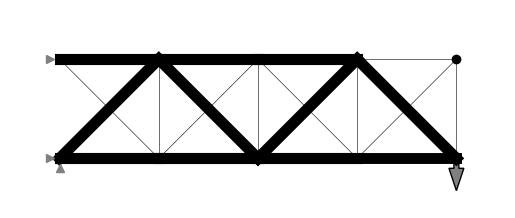

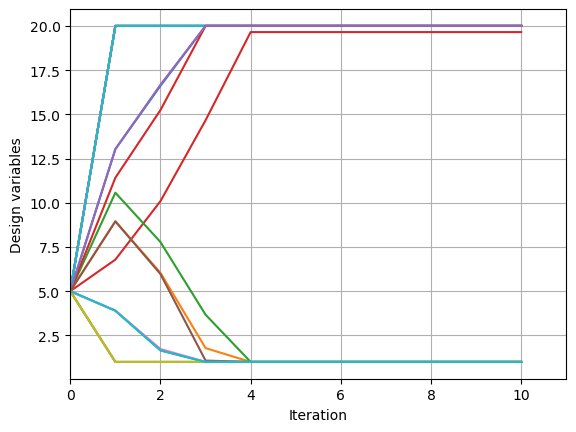

In [8]:
a_0 = 5.0 * torch.ones((len(truss_sample.elements)))
a_min = 1.0 * torch.ones_like(a_0)
a_max = 20.0 * torch.ones_like(a_0)
# Compute volume restriction
l = truss_sample.element_lengths()
V0 = 0.565 * torch.inner(a_max, l)

a_opt = optimize(truss_sample, a_0, a_min, a_max, V0, iter=10, p=2)
truss_sample.plot(show_thickness=True, node_labels=False)
plt.savefig("figures/truss_sample_topology_optimized.pdf", transparent=True, bbox_inches="tight")
plt.show()

plt.plot(range(len(a_opt)), torch.stack(a_opt))
plt.xlabel("Iteration")
plt.ylabel("Design variables")
plt.xlim([0, len(a_opt)])
plt.grid()
plt.show()